In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis.gensim_models

nltk.download('stopwords')
nltk.download('punkt')

nlp = spacy.load('en_core_web_sm')

nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Custom preprocessing functions
def remove_special_chars_and_punctuation(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_single_alphabet_tokens(text):
    return re.sub(r'\b[a-zA-Z]\b', '', text)

def remove_numerical_tokens(text):
    return re.sub(r'\b\d+\b', '', text)

def remove_alphanumeric_tokens(text):
    return re.sub(r'\b(?=.*\d)(?=.*[a-zA-Z])[a-zA-Z0-9]+\b', '', text)

def remove_pgp_key_patterns(text):
    return re.sub(r'\b(pgp|begin|end|key|public|block)\b', '', text, flags=re.IGNORECASE)

def remove_tokens_with_non_standard_characters(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

# Final custom preprocessing function, including stopword removal with NLTK
def custom_preprocessor(text):
    text = remove_special_chars_and_punctuation(text)
    text = remove_single_alphabet_tokens(text)
    text = remove_numerical_tokens(text)
    text = remove_alphanumeric_tokens(text)
    text = remove_pgp_key_patterns(text)
    text = remove_tokens_with_non_standard_characters(text)
    
    # Tokenizing and removing stopwords using NLTK
    words = text.lower().split()
    words = [word for word in words if word not in nltk_stopwords]
    
    # Rejoining words into a single string
    return ' '.join(words)

In [3]:
# Loading the dataset
input_file_path = 'cleaned_english_posts.csv' 
data = pd.read_csv(input_file_path)

# Applying the preprocessing directly to the 'post_content' column
data['processed_content'] = data['post_content'].apply(lambda x: custom_preprocessor(str(x)))

# Removing rows where 'processed_content' is empty after preprocessing
data = data[data['processed_content'].str.strip() != '']

In [9]:
# Getting the unique years from the dataset
years = data['year'].unique()

In [4]:
fasttext_model_path = 'final_fasttext_model.bin'

# Loading the FastText model
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=True)

print(f"FastText model loaded from {fasttext_model_path}")

FastText model loaded from final_fasttext_model.bin


In [5]:
# Function to calculate topic diversity for each year's LDA model
def calculate_topic_diversity(lda_model, num_top_words=30):
    topics = lda_model.show_topics(num_topics=-1, num_words=num_top_words, formatted=False)
    all_top_words = [word for topic in topics for word, _ in topic[1]]
    unique_words = set(all_top_words)
    total_words = len(all_top_words)
    topic_diversity_score = len(unique_words) / total_words if total_words > 0 else 0
    return topic_diversity_score

# Function to save the top 30 words for each topic from all years into a single text file
def save_top_words(lda_model, year, num_words=30, filename='baseline_LDA_top_words_all_years.txt'):
    with open(filename, 'a') as f:
        f.write(f"Year: {year}\n")
        f.write("=" * 40 + "\n")
        for idx, topic in lda_model.print_topics(num_topics=-1, num_words=num_words):
            f.write(f"Topic {idx + 1}:\n")
            f.write(topic + '\n\n')
        f.write("\n\n")
    print(f"Top {num_words} words for each topic saved for year {year} into {filename}.")

In [6]:
# Initialize lists to store results
topic_diversity_scores = []
iwec_scores_per_year = {}
years_list = []
doc_counts = []

# Initialize variables for weighted averaging
total_docs = 0
weighted_diversity = 0
overall_weighted_iwec = 0


In [10]:
# Parameters for LDA model
num_topics = 10  # Adjust the number of topics as needed
random_state = 42  # Set a fixed random state for reproducibility
passes = 10  # Increased passes for better convergence
iterations = 100  # Increased iterations for better convergence
n_top_words = 10  # Number of top words per topic

for year in years:
    # Filtering the DataFrame for the specific year
    df_year = data[data['year'] == year]
    
    # Tokenizing the processed content for LDA
    tokenized_corpus_lda = [doc.split() for doc in df_year['processed_content'].tolist()]
    
    # Creating a dictionary representation of the documents
    dictionary = Dictionary(tokenized_corpus_lda)
    
    # Creating a corpus: list of lists of tuples (word_id, word_frequency)
    corpus_bow = [dictionary.doc2bow(text) for text in tokenized_corpus_lda]

    # Training the LDA model using the corpus
    lda_model = LdaModel(
        corpus=corpus_bow, 
        id2word=dictionary, 
        num_topics=num_topics, 
        passes=passes,
        iterations=iterations,
        random_state=random_state
    )
    
    # Calculate Topic Diversity
    topic_diversity_score = calculate_topic_diversity(lda_model)
    
    # Save top 30 words for each topic
    save_top_words(lda_model, year)
    
    # Generate and save PyLDAvis visualization
    vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
    vis_file_path = f'baseline_lda_visualization_{year}.html'

    # Save the prepared PyLDAvis visualization to an HTML file
    pyLDAvis.save_html(vis_data, vis_file_path)
    print(f"LDA visualization for {year} saved to: {vis_file_path}")
    
    # Get the number of documents for this year
    num_docs = len(df_year)
    
    # Accumulating document count
    total_docs += num_docs

    # Accumulating weighted topic diversity
    weighted_diversity += topic_diversity_score * num_docs

    # Storing topic diversity per year for plotting
    topic_diversity_scores.append(topic_diversity_score)
    years_list.append(year)
    doc_counts.append(num_docs)
    
    ### IWEC Calculation Starts Here ###
    # Extract the top N words for each topic
    topics = lda_model.show_topics(num_topics=num_topics, num_words=n_top_words, formatted=False)
    
    # Organizing the topics into a list of word lists
    topic_words = []
    for topic_no, topic in topics:
        words = [word for word, prob in topic]
        topic_words.append(words)
    
    # Now, computing IWEC for these topics
    iwec_scores = []
    for words in topic_words:
        # Retrieve embeddings for the words
        embeddings = [fasttext_model[word] for word in words]
        # Compute pairwise cosine similarities
        similarities = cosine_similarity(embeddings)
        # Extract upper triangle without the diagonal
        idx_upper = np.triu_indices_from(similarities, k=1)
        coherence = np.mean(similarities[idx_upper])
        iwec_scores.append(coherence)
    
    # Getting topic distribution for each document
    topic_distributions = lda_model.get_document_topics(corpus_bow)
    
    # Initializing a list to store topic counts
    topic_counts = [0] * num_topics
    
    # Summing up the topic probabilities for all documents
    for doc_topics in topic_distributions:
        for topic_id, prob in doc_topics:
            topic_counts[topic_id] += prob
    
    # Calculating total topic weight
    total_topic_weight = sum(topic_counts)
    
    # Normalizing to get topic proportions
    topic_proportions = [count / total_topic_weight for count in topic_counts]
    
    # Computing weighted average IWEC score for the year
    weighted_iwec_score = sum([iwec * weight for iwec, weight in zip(iwec_scores, topic_proportions)])
    
    # Storing the weighted IWEC score
    iwec_scores_per_year[year] = weighted_iwec_score
    
    # Accumulating overall weighted IWEC score
    overall_weighted_iwec += weighted_iwec_score * num_docs

    print(f"Year {year}: Topic Diversity Score = {topic_diversity_score:.4f}, Weighted IWEC Score = {weighted_iwec_score:.4f}")

Top 30 words for each topic saved for year 2024 into baseline_LDA_top_words_all_years.txt.
LDA visualization for 2024 saved to: baseline_lda_visualization_2024.html
Year 2024: Topic Diversity Score = 0.6800, Weighted IWEC Score = 0.3695
Top 30 words for each topic saved for year 2021 into baseline_LDA_top_words_all_years.txt.
LDA visualization for 2021 saved to: baseline_lda_visualization_2021.html
Year 2021: Topic Diversity Score = 0.4500, Weighted IWEC Score = 0.3505
Top 30 words for each topic saved for year 2023 into baseline_LDA_top_words_all_years.txt.
LDA visualization for 2023 saved to: baseline_lda_visualization_2023.html
Year 2023: Topic Diversity Score = 0.7400, Weighted IWEC Score = 0.3597
Top 30 words for each topic saved for year 2022 into baseline_LDA_top_words_all_years.txt.
LDA visualization for 2022 saved to: baseline_lda_visualization_2022.html
Year 2022: Topic Diversity Score = 0.6900, Weighted IWEC Score = 0.3746
Top 30 words for each topic saved for year 2020 into

Weighted Average Topic Diversity Score Across Years: 0.6689
Overall Weighted Average IWEC Score Across Years: 0.3651


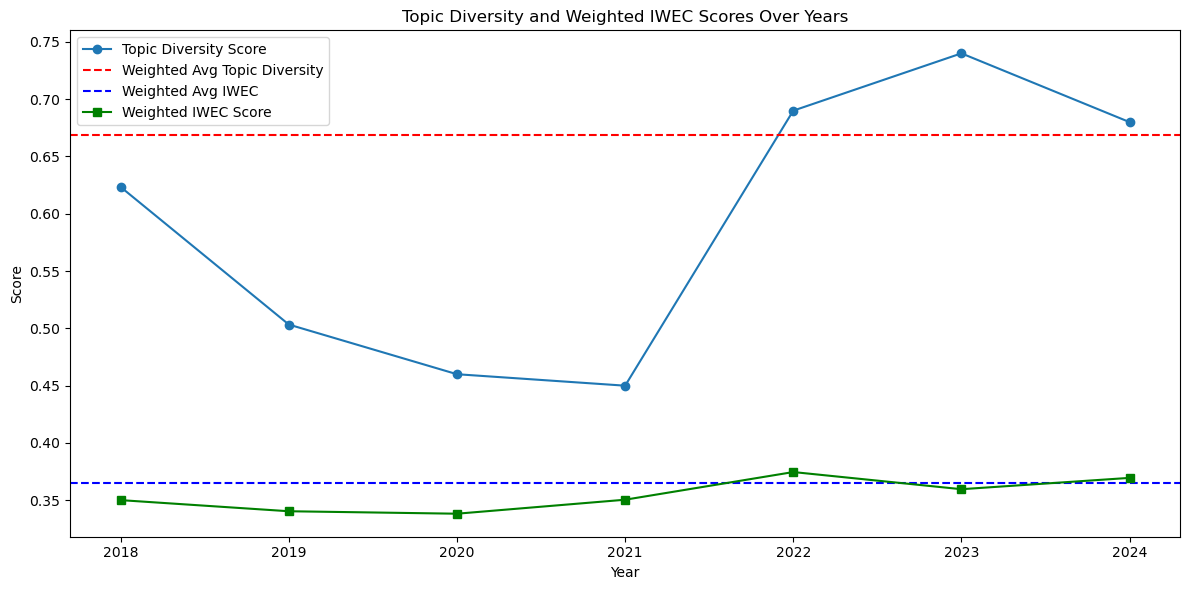

In [13]:
# Final weighted average topic diversity
avg_weighted_diversity = weighted_diversity / total_docs

# Final overall weighted average IWEC score
avg_weighted_iwec = overall_weighted_iwec / total_docs

print(f"Weighted Average Topic Diversity Score Across Years: {avg_weighted_diversity:.4f}")
print(f"Overall Weighted Average IWEC Score Across Years: {avg_weighted_iwec:.4f}")

# Sorting years and corresponding scores for proper plotting
sorted_years_data = sorted(zip(years_list, topic_diversity_scores), key=lambda x: x[0])
sorted_years_list, sorted_topic_diversity_scores = zip(*sorted_years_data)

# Sorting IWEC scores
sorted_years_iwec = sorted(iwec_scores_per_year.keys())
sorted_iwec_scores = [iwec_scores_per_year[year] for year in sorted_years_iwec]

plt.figure(figsize=(12, 6))

# Plotting Topic Diversity Scores
plt.plot(sorted_years_list, sorted_topic_diversity_scores, marker='o', label='Topic Diversity Score')
plt.axhline(y=avg_weighted_diversity, color='r', linestyle='--', label='Weighted Avg Topic Diversity')
plt.axhline(y=avg_weighted_iwec, color='b', linestyle='--', label='Weighted Avg IWEC')

# Plotting IWEC Scores on the same graph
plt.plot(sorted_years_iwec, sorted_iwec_scores, marker='s', color='green', label='Weighted IWEC Score')

plt.title('Topic Diversity and Weighted IWEC Scores Over Years')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()